输出路径：```./Exp-of-Junli/output_video```

In [1]:
# 导入必要的库
import os
import cv2
import numpy as np
import sys
sys.path.append('../')
import subprocess
from datetime import datetime
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from ffmpy import FFmpeg
from collections import OrderedDict
import warnings
import torchlm
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from config.config import DINetTrainingOptions
from torchlm.tools import faceboxesv2
from torchlm.models import pipnet
from tensor_processing import *
from audio_processing import extract_deepspeech

# 项目特定的模块
from models.LawDNet import LawDNet

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # 使CUDA错误更易于追踪
warnings.filterwarnings("ignore")  # 初始化和配置警告过滤，忽略不必要的警告


2024-03-16 04:57:08.161672: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
args = ['--opt.mouth_region_size','288']
        
opt = DINetTrainingOptions().parse_args(args)

os.environ["CUDA_VISIBLE_DEVICES"] = opt.cuda_devices
print(" torch.cuda.device_count() ",torch.cuda.device_count())
print(" torch.cuda.get_device_name(0) ",torch.cuda.get_device_name(0))
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'

# 导入配置文件更新opt

out_W = int(opt.mouth_region_size * 1.25) # 输出视频的宽度 # 360
B = 20  # batchsize 并行化推理
output_name = '5kp-60standard—epoch60-720P-复现'

video_path = './WRA_KevinMcCarthy0_001.mp4'
audio_path = './template/test_chinese_wav_man_tts.wav'
# 如果是从音频文件提取DeepSpeech特征
# deepspeech_tensor, _ = extract_deepspeech(audio_path, deepspeech_model_path)
# torch.save(deepspeech_tensor, './template/test_chinese_wav_man_tts.pt')

# 直接从已保存的Tensor文件加载
deepspeech_tensor = torch.load('./template/test_chinese_wav_man_tts.pt')
print(f"Loaded DeepSpeech features tensor shape: {deepspeech_tensor.shape}")

max_frames = 100  # 使用本段视频的帧数  # None

 torch.cuda.device_count()  4
 torch.cuda.get_device_name(0)  NVIDIA GeForce RTX 4090
Loaded DeepSpeech features tensor shape: torch.Size([579, 29, 5])


#### 加载预训练模型 320
- 常用路径：/home/dengjunli/data/dengjunli/autodl拿过来的/DINet-update/asserts/training_model_weight-标准框60关键点8/clip_training_256/netG_model_epoch_38.pth
- 关键点是5！！ standard_grid_size是60  训练时 mouth_size是256

#### 加载预训练模型 360
- ../asserts/training_model_weight/clip_training_256/netG_model_epoch_60.pth
- /home/dengjunli/data/dengjunli/autodl拿过来的/DINet-update/asserts/training_model_weight-360分辨率正式模型备份/clip_training_256/netG_model_epoch_60.pth
- 关键点是5！！ standard_grid_size是60  训练时 mouth_size是288

In [3]:
# 设置模型文件路径
deepspeech_model_path = "../asserts/output_graph.pb"  # DeepSpeech模型文件路径

lawdnet_model_path =  "../output/training_model_weight/288-mouth-复现-DDP-set-seed/clip_training_256/netG_model_epoch_80.pth"

# 其他模型文件路径，可根据需要取消注释使用
# lawdnet_model_path = "../asserts/training_model_weight-标准框60关键点8/clip_training_256/netG_model_epoch_38.pth"  # 标准框，60关键点5训练的模型
## ⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️⬇️最好的
# lawdnet_model_path = "../asserts/training_model_weight-360分辨率正式模型备份/clip_training_256/netG_model_epoch_60.pth"  # 大嘴标准框，60关键点5训练的模型


In [4]:
def read_video_np(video_path, max_frames=None):
    """
    读取视频文件并将其转换为帧序列。
    
    参数:
    video_path (str): 视频文件的路径。
    max_frames (int): 最大读取帧数。默认为800，如果设置为None，则读取整个视频。
    
    返回:
    list: 包含视频帧的列表。
    """
    cap = cv2.VideoCapture(video_path)  # 创建视频捕获对象
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # 获取视频帧数
    H, W = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # 获取视频的高和宽
    print('video length: ', length)
    print('video size: ', 'H--', H, 'W--', W)
    
    frames = []  # 初始化帧列表
    i = 0  # 帧计数器
    while True:
        ret, frame = cap.read()  # 读取下一帧
        if not ret:
            break  # 如果读取失败，结束循环
        frames.append(frame)  # 如果读取成功，添加到列表中
        
        i += 1
        if max_frames is not None and i >= max_frames:  # 检查是否达到最大帧数限制
            break

    cap.release()  # 释放视频捕获对象
    return frames


In [5]:


# 从视频路径中提取视频文件名（无扩展名）
video_name = os.path.splitext(os.path.basename(video_path))[0]

# 将视频名称添加到输出名称中，以创建唯一的输出标识符
output_name = f"{output_name}_{video_name}"

# 读取视频帧并转换为numpy数组
video_frames = read_video_np(video_path, max_frames)  # 读取视频帧
video_frames = np.array(video_frames, dtype=np.float32)

# 将视频帧从BGR转换为RGB格式
video_frames = video_frames[..., ::-1]  # 使用...保持前面的维度不变，只反转最后一个维度

# 打印视频帧数组的形状
print("使用的视频 ",video_frames.shape)


video length:  1127
video size:  H-- 720 W-- 1280
使用的视频  (100, 720, 1280, 3)


### 提取原声音频

In [6]:
# # 定义资源和结果目录
# res_audio_dir = './template'
# video_basename = os.path.basename(video_path)
# audio_basename = video_basename.replace('.mp4', '.wav')
# audio_path = os.path.join(res_audio_dir, audio_basename)

# # 提取视频中的音频
# print(f'Extracting audio from video: {video_basename}')
# # 使用ffmpeg提取音频，将采样率设置为16000Hz
# # subprocess.call(f'ffmpeg -y -i "{video_path}" -f wav -ar 16000 "{audio_path}"', shell=True)

# # 提取音频特征或加载已保存的特征
# # deepspeech_tensor, _ = extract_deepspeech(audio_path, deepspeech_model_path)
# # torch.save(deepspeech_tensor, audio_path.replace('.wav', '.pt'))

# # 加载已保存的DeepSpeech特征
# deepspeech_tensor = torch.load(audio_path.replace('.wav', '.pt'))

### 并行化推理

In [7]:
# 确定输出长度，以适应最小的帧数或特征长度，并确保它是batch size的倍数
len_out = min(len(video_frames), deepspeech_tensor.shape[0]) // B * B

# 调整视频帧和DeepSpeech特征数组的长度以匹配len_out
video_frames = video_frames[:len_out]
deepspeech_tensor = deepspeech_tensor[:len_out]

### 加载lawdnet模型

In [8]:
# 加载LawDNet模型
net_g = LawDNet(opt.source_channel, opt.ref_channel, opt.audio_channel, 
                opt.warp_layer_num, opt.num_kpoints, opt.coarse_grid_size).to(device) # 2个输出通道，5个关键点
checkpoint = torch.load(lawdnet_model_path)
state_dict = checkpoint['state_dict']['net_g']

# 修正模型权重命名并加载
new_state_dict = OrderedDict((k[7:], v) for k, v in state_dict.items())  # 移除前缀'module.'
net_g.load_state_dict(new_state_dict)
net_g.eval()

# 初始化面部对齐和平滑平方掩码器
facealigner = FaceAlign(ratio=1.6, device=device) # 固定比例1.6
sqmasker = SmoothSqMask(device=device).to(device) # 直接使用cuda()，假设环境已经设定好


### 提取landmark，用于正脸化

In [9]:
# 绑定模型到指定设备
torchlm.runtime.bind(faceboxesv2(device=device))
torchlm.runtime.bind(pipnet(backbone="resnet18", pretrained=True, num_nb=10, num_lms=68, net_stride=32,
                            input_size=256, meanface_type="300w", map_location=device.__str__()))

# 提取第一帧的landmarks作为初始化
landmarks, _ = torchlm.runtime.forward(video_frames[0])

# 批量处理视频帧以提取landmarks
# 初始化landmarks列表
landmarks_list = []

# 对视频帧进行遍历，逐帧提取landmarks
for frame in tqdm(video_frames, desc='Processing video frames, extracting landmarks...'):
    # 对当前帧进行landmark和bounding box的提取
    landmarks, bboxes = torchlm.runtime.forward(frame)
    
    # 根据置信度（bounding box的第五个元素）选择最可信的landmark
    highest_trust_index = np.argmax(bboxes[:, 4])
    most_trusted_landmarks = landmarks[highest_trust_index]
    
    # 将选中的landmarks添加到列表中
    landmarks_list.append(most_trusted_landmarks)

# 转换landmarks列表为numpy数组
landmarks_list = np.array(landmarks_list)


# 转换landmarks列表为numpy数组
landmarks_list = np.array(landmarks_list)


Processing video frames, extracting landmarks...: 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


reference_tensor.shape: torch.Size([5, 3, 468, 360])


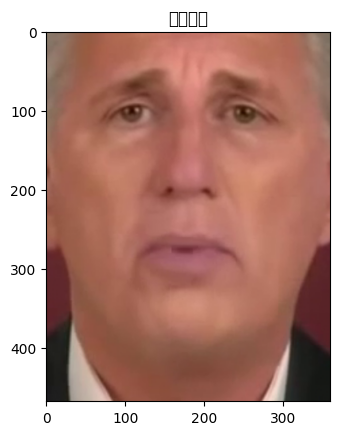

In [10]:
# 随机选择5帧作为参考帧，或者手动指定参考帧索引
reference_index = torch.randint(0, len(video_frames), (5,)).tolist()
# reference_index = [6, 0, 0, 0, 0]

# 从视频帧中提取参考帧并转换为张量
reference_tensor = torch.tensor(video_frames[reference_index], dtype=torch.float).to(device)
# 调整张量维度以匹配网络输入 [batch_size, channels, height, width]
reference_tensor = reference_tensor.permute(0, 3, 1, 2)

# 从landmarks列表中提取对应的参考landmarks
reference_landmarks = torch.tensor(landmarks_list[reference_index], dtype=torch.float).to(device)

# 使用facealigner调整参考帧和参考landmarks，确保它们与目标分辨率匹配
reference_tensor, _, _ = facealigner(reference_tensor, reference_landmarks, out_W=out_W)

# 显示第一帧参考图像
plt.imshow(reference_tensor[0].permute(1, 2, 0).cpu().numpy().astype(np.uint8))
# plt.axis('off')  # 不显示坐标轴
plt.title('参考图像')
plt.savefig('生成图source_img.png', bbox_inches='tight', pad_inches=0)

# 将参考张量的值归一化到[0, 1]范围
reference_tensor = reference_tensor / 255.0
print(f"reference_tensor.shape: {reference_tensor.shape}")

# 获取固定口型的参考帧


In [11]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np
# from PIL import Image
# import os

# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# # Image file names
# image_filenames = ['e.jpg', 'f.jpg', 's.jpg', 'p.jpg', 'w.jpg']
# # Base path to the images
# base_path = '../asserts/training_data/split_video_25fps_crop_face/WDA_KatieHill_000_25fps/'

# # Initialize the list to hold the reference tensors
# reference_tensors = []

# # Loop through each image file
# for filename in image_filenames:
#     # Load the image
#     image_path = os.path.join(base_path, filename)
#     image = Image.open(image_path).convert('RGB')
    
#     # Convert the image to a numpy array and then to a tensor
#     image_tensor = torch.from_numpy(np.array(image)).to(device)
    
#     # Rearrange the tensor dimensions to be in the (C, H, W) format
#     image_tensor = image_tensor.permute(2, 0, 1)
    
#     # Add the image tensor to the reference tensors list
#     reference_tensors.append(image_tensor)

# # Stack all reference tensors to create a batch
# reference_tensor = torch.stack(reference_tensors).cuda().float() / 255.0

# # Insert loading landmarks_list
# # reference_landmarks = load corresponding landmarks for the images here

# # Align faces based on landmarks
# # reference_tensor, _, _ = facealigner(reference_tensor, reference_landmarks, out_W=out_W)  # 修改分辨率时切记此参数！！！！！

# out_W = out_W  # 目标宽度
# aspect_ratio = reference_tensor.shape[2] / reference_tensor.shape[3]  # 假设所有图像具有相同的宽高比
# out_H = int(out_W * aspect_ratio)  # 根据宽度计算高度以保持等比例

# print("reference_tensor.shape:", reference_tensor.shape)

# # 使用 torch.nn.functional.interpolate 对整个批次进行缩放
# reference_tensors = F.interpolate(reference_tensor.cuda().float(), size=(out_H, out_W), mode='bilinear', align_corners=False)


# # Display the first image in the tensor
# # plt.imshow((reference_tensor[0]*255).permute(1, 2, 0).cpu().numpy().astype(np.uint8))

# ## 设置图像显示的大小
# plt.figure(figsize=(15, 3))  # 设置足够宽以容纳五张图像

# # 遍历五张图像的张量
# for i in range(len(reference_tensors)):
#     plt.subplot(1, 5, i + 1)  # 创建子图(1行5列)
#     img = (reference_tensors[i]).permute(1, 2, 0).cpu().numpy().astype(np.uint8)  # 将张量转换为图像格式
#     plt.imshow(img)  # 显示图像(需要将RGB转换为BGR)
#     plt.title(image_filenames[i], fontsize=10)  # 为每张图像设置标题，使用对应的文件名
#     # plt.axis('off')  # 隐藏坐标轴

# plt.tight_layout()  # 调整子图间距
# plt.show()  # 显示图像

### 有一个修改分辨率的参数请注意
#### 不增大嘴部时：
- 模型：/home/dengjunli/data/dengjunli/autodl拿过来的/DINet-update/asserts/training_model_weight-标准框60关键点8/clip_training_256/netG_model_epoch_38.pth
- out_W = 320
- size = 416 320

#### 增大嘴部时：
- out_W = 360
- 模型：/home/dengjunli/data/dengjunli/autodl拿过来的/DINet-update/asserts/training_model_weight-360分辨率正式模型备份/clip_training_256/netG_model_epoch_60.pth
- size = 468 360

In [12]:
def reference(model, masked_source, reference, audio_tensor):
    with torch.no_grad():
        return model(masked_source, reference, audio_tensor)

visualize_every_n_batches = 30  # 指定可视化的批次间隔
outframes = np.zeros_like(video_frames)  # 初始化输出帧数组

for i in tqdm(range(len_out // B), desc="处理批次"):
    # 准备源视频帧和landmarks的张量
    source_tensor = torch.tensor(video_frames[i * B:(i + 1) * B].copy(), dtype=torch.float).to(device).permute(0, 3, 1, 2)
    landmarks_tensor = torch.tensor(landmarks_list[i * B:(i + 1) * B], dtype=torch.float).to(device)
    
    # 使用facealigner对视频帧进行预处理
    feed_tensor, _, affine_matrix = facealigner(source_tensor, landmarks_tensor, out_W=out_W)
    _, C, H, W = feed_tensor.shape

    # 应用掩码处理
    feed_tensor_masked = sqmasker(feed_tensor / 255.0)
    
    # 准备参考帧和音频张量
    reference_tensor_B = reference_tensor.unsqueeze(0).expand(B, -1, -1, -1, -1).reshape(B, 5 * 3, H, W)
    audio_tensor = deepspeech_tensor[i * B:(i + 1) * B].to(device)
    
    # 生成输出
    # print("feed_tensor_masked.shape", feed_tensor_masked.shape)
    # print("reference_tensor_B.shape", reference_tensor_B.shape)
    # print("audio_tensor.shape", audio_tensor.shape)
    
    output_B = reference(net_g, feed_tensor_masked, reference_tensor_B, audio_tensor).float().clamp_(0, 1)
    
    # 恢复到原始尺寸和位置
    outframes_B = facealigner.recover(output_B * 255.0, source_tensor, affine_matrix).permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)
    
    # 更新输出帧数组
    outframes[i * B:(i + 1) * B] = outframes_B

    # 可视化输出
    if i % visualize_every_n_batches == 0:
        plt.figure(figsize=(10, 5))
        plt.imshow(outframes_B[0])
        plt.title(f"Batch {i} - First output image")
        # plt.axis('off')
        plt.show()


处理批次:   0%|          | 0/5 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:2 and cuda:0! (when checking argument for argument weight in method wrapper_CUDA__cudnn_convolution)

# 展示output图像

In [ ]:
reference_tensor_B.shape

torch.Size([20, 15, 468, 360])

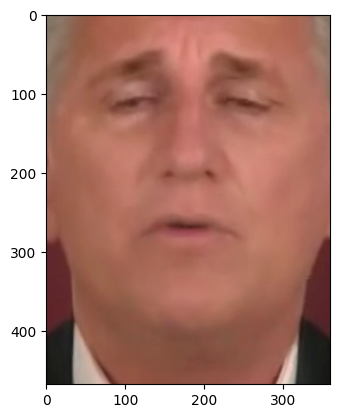

In [ ]:
plt.imshow((output_B[1]*255.0).permute(1,2,0).cpu().numpy().astype(np.uint8))

In [ ]:
outframes = outframes.astype(np.uint8) 
outframes = outframes[:,:,:,::-1] # RGB to BGR

# 准备输出视频的路径
timestamp_str = datetime.now().strftime('%Y%m%d_%H%M%S')
output_path = f'./{timestamp_str}.mp4'

# 初始化视频写入器
fourcc = cv2.VideoWriter_fourcc(*'XVID')
videoWriter = cv2.VideoWriter(output_path, fourcc, 25, (video_frames.shape[2], video_frames.shape[1]), True)

# 将处理后的帧写入视频文件
for frame in outframes:
    videoWriter.write(frame)

# 释放视频写入器资源
videoWriter.release()


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


### 视频添加音频

In [ ]:

def video_add_audio(video_path: str, audio_path: str, output_dir: str) -> str:
    # 检查output_dir是否存在
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 检查音频格式是否支持
    _ext_audio = audio_path.split('.')[-1]
    if _ext_audio not in ['mp3', 'wav']:
        raise ValueError('Audio format not supported.')

    # 根据音频格式选择编码器
    _codec = 'copy' if _ext_audio == 'mp3' else 'aac'

    # 构造输出视频文件的完整路径
    video_basename_without_ext = os.path.splitext(os.path.basename(video_path))[0]
    output_video_path = os.path.join(output_dir, f"{video_basename_without_ext}_{output_name}.mp4")

    # 使用ffmpeg合并视频和音频
    ff_command = f"ffmpeg -i \"{video_path}\" -i \"{audio_path}\" -map 0:v -map 1:a -c:v copy -c:a {_codec} -shortest \"{output_video_path}\""
    os.system(ff_command)

    # 删除临时视频文件
    # os.remove(video_path)

    return output_video_path

# 调用函数，将音频添加到视频
result_video_path = video_add_audio(output_path, audio_path, './output_video')



ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/dengjunli/miniconda3 --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.

In [ ]:
print(f"Generated video with audio at: {result_video_path}")

Generated video with audio at: ./output_video/20240314_090756_5kp-60standard—epoch60-720P-复现_WRA_KevinMcCarthy0_001.mp4


## 改变音频的通道数-供别的代码talklip使用（推理时不用）

In [ ]:
# from scipy.io import wavfile
# import numpy as np

# # 读取wav文件
# audio_path = './template/WRA_JebHensarling0_000.wav'
# sample_rate, audio_data = wavfile.read(audio_path)

# # 获取通道数
# if len(audio_data.shape) == 1:
#     channels = 1  # 单通道（单声道）
# else:
#     channels = audio_data.shape[1]  # 多通道（如立体声）

# print(f"Sample Rate: {sample_rate} Hz")
# print(f"Channels: {channels}")

# # 检查是否为双声道
# if len(audio_data.shape) == 2 and audio_data.shape[1] == 2:
#     audio_mono = np.mean(audio_data, axis=1, dtype=audio_data.dtype)  # 平均左右通道
# else:
#     audio_mono = audio_data  # 如果已经是单声道，不需要更改

# # 只保留前40秒的音频
# audio_mono = audio_mono[:sample_rate*10]

# # 保存为单声道wav文件
# wavfile.write(audio_path.replace('.wav','_1_channel_10s.wav'), sample_rate, audio_mono)